In [19]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.stats import ranksums
import gseapy
from gseapy.plot import barplot, dotplot
from numpy.linalg import eigh, eig
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm
import time

import get_hic_map_of_MEFISTO_loci as MEFISTO

In [20]:
# Reload modules in case of modifications
reload(MEFISTO)

<module 'get_hic_map_of_MEFISTO_loci' from '/home/braunger/masterthesis/python_code/MEFISTO/get_hic_map_of_MEFISTO_loci.py'>

## Load Hi-C data of MEFISTO loci

In [21]:
data_dir = '/home/braunger/masterthesis/data/'
hic_dir = '/home/braunger/masterthesis/save/processed_hic_data/'
activity_dir = '/home/braunger/masterthesis/save/active_loci/'
save_dir = '/home/braunger/masterthesis/save/figures/MEFISTO/'
resol = 250000

In [22]:
# Selected MEFISTO loci:
# get df with the top weighted genes from MEFISTO
pos_weights = pd.read_csv(data_dir+'MOFA/top_genes_pos_0.1.csv')
pos_weights['sign'] = 'positive'
neg_weights = pd.read_csv(data_dir+'MOFA/top_genes_neg_0.1.csv')
neg_weights['sign'] = 'negative'
selected_genes = pd.concat([pos_weights, neg_weights])

In [23]:
# Get Hi-C data for selected loci (matrices generated with get_hic_map_of_MEFISTO_loci)
IMR90 = pd.read_csv(hic_dir+'processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/MEFISTO.csv', index_col = 0)
old_fibroblasts = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/MEFISTO.csv', index_col = 0)

# if all zero column exists, remove column and row corresponding to that locus
IMR90 = IMR90.loc[:, (IMR90 != 0).any(axis=0)]
IMR90 = IMR90.T.loc[:, (IMR90.T != 0).any(axis=0)].T

old_fibroblasts = old_fibroblasts.loc[:, (old_fibroblasts != 0).any(axis=0)]
old_fibroblasts = old_fibroblasts.T.loc[:, (old_fibroblasts.T != 0).any(axis=0)].T

## Clustering on all selected loci

<Figure size 432x288 with 0 Axes>

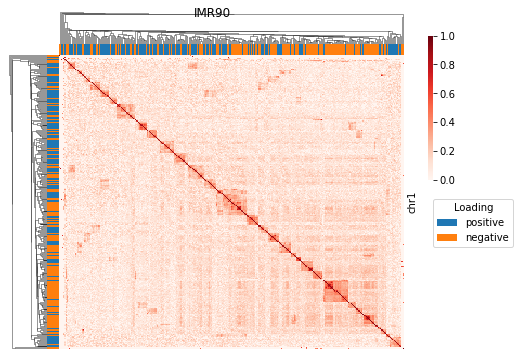

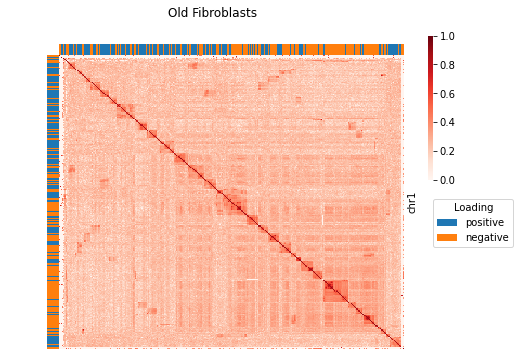

In [24]:
%matplotlib inline
MEFISTO.plot_clusters_pairs(IMR90, "IMR90", old_fibroblasts, "Old Fibroblasts", selected_genes)

<Figure size 432x288 with 0 Axes>

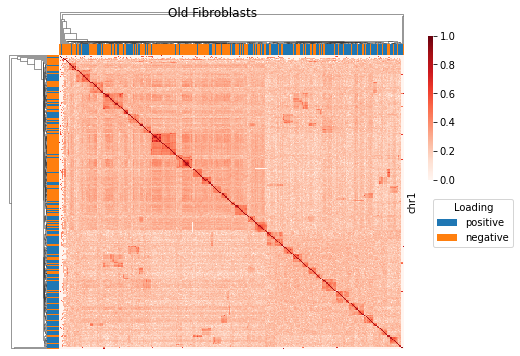

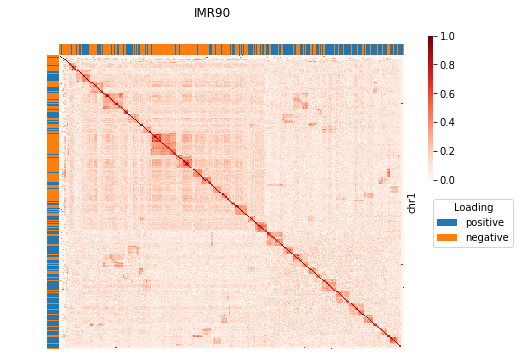

In [395]:
MEFISTO.plot_clusters_pairs(old_fibroblasts, "Old Fibroblasts", IMR90, "IMR90", selected_genes)

## Get clusters with maximal 5 chromosomes

In [340]:
# create dendrogram
dend_IMR90 = linkage(1 - IMR90, method='average', metric='cosine')
dend_old_fibroblasts = linkage(1 - old_fibroblasts, method='average', metric='cosine')

# numpy array containing the loci
loci_young = IMR90.columns.to_numpy()
loci_old = old_fibroblasts.columns.to_numpy()

# dictionary that maps each loci to its chromosome
loci2chrom_young = {}
for loc in loci_young:
    loci2chrom_young[loc] = loc.split("_")[1]
    
loci2chrom_old = {}
for loc in loci_old:
    loci2chrom_old[loc] = loc.split("_")[1]

In [341]:
# find threshold to cut the dendrogram such that there are max 5 chromosomes per cluster
t_IMR90 = MEFISTO.get_4chrom_clustering(dend_IMR90, loci_young, loci2chrom_young, max_chrom = 5, inc = 0.0001)
t_old_fibroblasts = MEFISTO.get_4chrom_clustering(dend_old_fibroblasts, loci_old, loci2chrom_old, max_chrom = 5, inc = 0.0001)
print('Threshold for IMR90: ' + str(t_IMR90))
print('Threshold for Old Fibroblasts: ' + str(t_old_fibroblasts))

Threshold for IMR90: 0.0048
Threshold for Old Fibroblasts: 0.0055


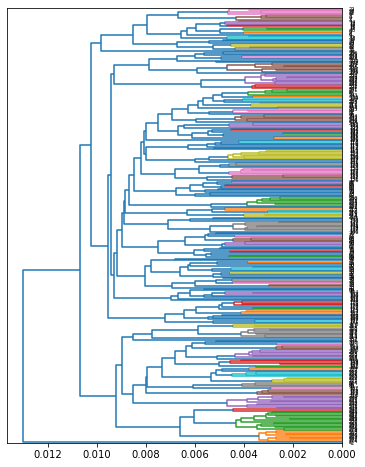

In [342]:
plt.figure(figsize = (6, 8))
dendrogram(dend_IMR90, orientation = "left", color_threshold = t_IMR90)
plt.savefig(save_dir+'dendrogram_IMR90.png')
plt.show()

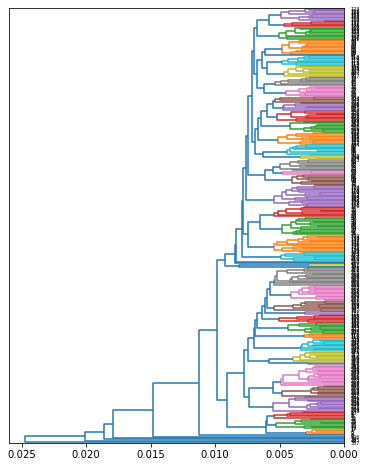

In [343]:
plt.figure(figsize = (6, 8))
dendrogram(dend_old_fibroblasts, orientation = "left", color_threshold = t_old_fibroblasts)
plt.savefig(save_dir+'dendrogram_old_fibroblasts.png')
plt.show()

In [344]:
# get clusters for the given threshold
# IMR90
clusters_IMR90 = fcluster(dend_IMR90, t_IMR90, criterion = 'distance')
loci_clusters_IMR90 = pd.DataFrame({'locus': loci_young, 'cluster': clusters_IMR90})
loci_clusters_IMR90['chrom'] = loci_clusters_IMR90['locus'].str.split('_').str[1]
loci_clusters_IMR90['sign'] = np.where(loci_clusters_IMR90['locus'].isin(pos_weights['locus'].tolist()), "positive", "negative")

# Old fibroblasts
clusters_old_fibroblasts = fcluster(dend_old_fibroblasts, t_old_fibroblasts, criterion = 'distance')
loci_clusters_old_fibroblasts = pd.DataFrame({'locus': loci_old, 'cluster': clusters_old_fibroblasts})
loci_clusters_old_fibroblasts['chrom'] = loci_clusters_old_fibroblasts['locus'].str.split('_').str[1]
loci_clusters_old_fibroblasts['sign'] = np.where(loci_clusters_old_fibroblasts['locus'].isin(pos_weights['locus'].tolist()), "positive", "negative")

In [345]:
loci_clusters_IMR90

,locus,cluster,chrom,sign
0,chr_1_loc_750000,142,1,negative
1,chr_1_loc_1000000,142,1,negative
2,chr_1_loc_1250000,142,1,negative
3,chr_1_loc_1500000,142,1,negative
4,chr_1_loc_2000000,137,1,negative
...,...,...,...,...
313,chr_22_loc_36250000,20,22,positive
314,chr_22_loc_38750000,20,22,negative
315,chr_22_loc_41750000,20,22,negative
316,chr_22_loc_46250000,20,22,negative


## Visualize cluster statistics

In [346]:
# IMR90
cluster_list_IMR90 = list(range(1, max(loci_clusters_IMR90['cluster'])+1))
cluster_statistics_IMR90 = pd.DataFrame({'cluster': cluster_list_IMR90})

# add number of loci per cluster
cluster_statistics_IMR90['number_loci'] = [len(loci_clusters_IMR90.loc[loci_clusters_IMR90['cluster'] == cluster, 'locus']) for cluster in cluster_list_IMR90]

# add number of chromosomes per cluster
cluster_statistics_IMR90['number_chrom'] = [len(loci_clusters_IMR90.loc[loci_clusters_IMR90['cluster'] == cluster, 'chrom'].unique()) for cluster in cluster_list_IMR90]

In [347]:
# Old fibroblasts
cluster_list_old = list(range(1, max(loci_clusters_old_fibroblasts['cluster'])+1))
cluster_statistics_old_fibroblasts = pd.DataFrame({'cluster': cluster_list_old})

# add number of loci per cluster
cluster_statistics_old_fibroblasts['number_loci'] = [len(loci_clusters_old_fibroblasts.loc[loci_clusters_old_fibroblasts['cluster'] == cluster, 'locus']) for cluster in cluster_list_old]

# add number of chromosomes per cluster
cluster_statistics_old_fibroblasts['number_chrom'] = [len(loci_clusters_old_fibroblasts.loc[loci_clusters_old_fibroblasts['cluster'] == cluster, 'chrom'].unique()) for cluster in cluster_list_old]

In [348]:
cluster_statistics_IMR90

,cluster,number_loci,number_chrom
0,1,8,1
1,2,14,1
2,3,2,1
3,4,10,1
4,5,4,1
...,...,...,...
140,141,1,1
141,142,4,1
142,143,5,1
143,144,1,1


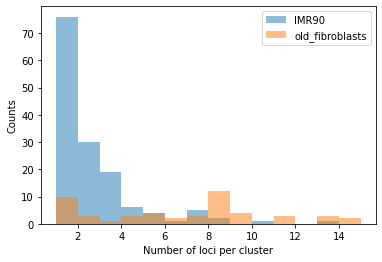

In [349]:
plt.figure()
plt.hist(cluster_statistics_IMR90['number_loci'], 
         bins=np.arange(min(cluster_statistics_IMR90['number_loci']), 
                        max(cluster_statistics_IMR90['number_loci']) + 1, 1), 
         alpha=0.5, label="IMR90")
plt.hist(cluster_statistics_old_fibroblasts['number_loci'], 
         bins=np.arange(min(cluster_statistics_old_fibroblasts['number_loci']), 
                        max(cluster_statistics_old_fibroblasts['number_loci']) + 1, 1), 
         alpha=0.5, label="old_fibroblasts")
plt.xlabel("Number of loci per cluster")
plt.ylabel("Counts")
plt.legend(loc = 'upper right')
plt.savefig(save_dir+'hist_loci_per_cluster.png')
plt.show()

### Analyse cluster with more than one chromosome in IMR90

In [350]:
cluster_statistics_IMR90[cluster_statistics_IMR90['number_chrom'] > 1]

,cluster,number_loci,number_chrom
117,118,5,5


In [323]:
# loci corresponding to the selected cluster
loci = loci_clusters_IMR90[loci_clusters_IMR90['cluster']==24]

# genes belonging to these loci
selection = selected_genes[selected_genes['locus'].isin(loci['locus'].tolist())]
selection

,ensembl_id,value,symbol,locus,sign
74,ENSG00000253506,0.504236,NACA2,chr_17_loc_61500000,positive
189,ENSG00000160255,0.409758,ITGB2,chr_21_loc_44750000,positive
199,ENSG00000100342,0.402202,APOL1,chr_22_loc_36250000,positive
12,ENSG00000013810,-0.814359,TACC3,chr_4_loc_1500000,negative
18,ENSG00000075218,-0.782161,GTSE1,chr_22_loc_46250000,negative
25,ENSG00000167900,-0.743018,TK1,chr_17_loc_78000000,negative
27,ENSG00000100162,-0.736135,CENPM,chr_22_loc_41750000,negative
30,ENSG00000076382,-0.730430,SPAG5,chr_17_loc_28500000,negative
31,ENSG00000089685,-0.725165,BIRC5,chr_17_loc_78000000,negative
33,ENSG00000100302,-0.724465,RASD2,chr_22_loc_35500000,negative


In [324]:
# GSEA of genes in cluster 
enr = gseapy.enrichr(gene_list=selection['symbol'].tolist(), 
                     gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='cluster_25', outdir=save_dir+'GO_c25', format='png',
                     verbose=False)
# Visualize results
enr.results.head(5)

/home/braunger/miniconda3/envs/hic/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,sister chromatid segregation (GO:0000819),3/32,0.000004,0.000762,0,0,121.405680,1504.116552,TOP2A;KIF18B;SPAG5
1,GO_Biological_Process_2018,mitotic nuclear division (GO:0140014),3/74,0.000053,0.004847,0,0,49.483844,487.201346,KIF18B;SPAG5;BIRC5
2,GO_Biological_Process_2018,protein sumoylation (GO:0016925),2/68,0.002080,0.072611,0,0,33.525253,207.028041,TOP2A;BIRC5
3,GO_Biological_Process_2018,mitotic sister chromatid segregation (GO:0000070),2/82,0.003007,0.072611,0,0,27.638889,160.490639,KIF18B;SPAG5
4,GO_Biological_Process_2018,peptidyl-lysine modification (GO:0018205),2/115,0.005820,0.072611,0,0,19.534907,100.535727,TOP2A;BIRC5


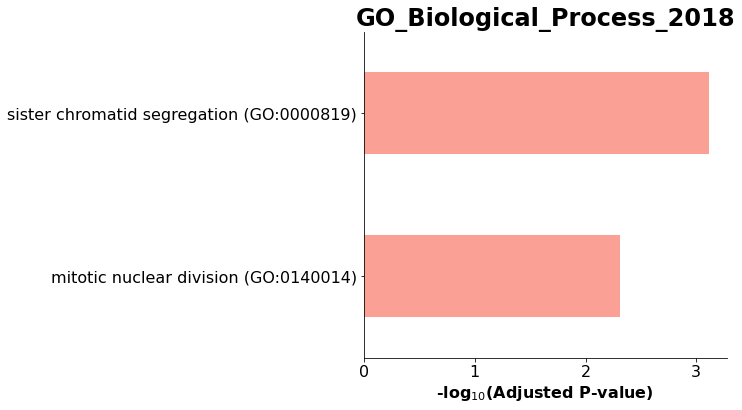

In [325]:
# Barplot
barplot(enr.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
        cutoff=0.01, top_term=20, figsize=(6.5, 6), color='salmon', ofname=None)

### Analyse clusters with more than one chromosome in old fibroblasts

In [326]:
cluster_statistics_old_fibroblasts[cluster_statistics_old_fibroblasts['number_chrom'] > 1]

,cluster,number_loci,number_chrom
19,20,8,2
20,21,13,5
25,26,5,3
39,40,9,4


#### Cluster 16

In [328]:
# loci corresponding to the selected cluster
loci = loci_clusters_old_fibroblasts[loci_clusters_old_fibroblasts['cluster']==20]

# genes belonging to these loci
selection = selected_genes[selected_genes['locus'].isin(loci['locus'].tolist())]
selection

,ensembl_id,value,symbol,locus,sign
86,ENSG00000122707,0.495780,RECK,chr_9_loc_36000000,positive
12,ENSG00000013810,-0.814359,TACC3,chr_4_loc_1500000,negative
110,ENSG00000130720,-0.611151,FIBCD1,chr_9_loc_130750000,negative
118,ENSG00000186193,-0.597478,SAPCD2,chr_9_loc_137000000,negative
134,ENSG00000171159,-0.582118,BBLN,chr_9_loc_128000000,negative
144,ENSG00000182154,-0.570564,MRPL41,chr_9_loc_137500000,negative
154,ENSG00000243449,-0.562880,C4orf48,chr_4_loc_2000000,negative
176,ENSG00000160446,-0.543276,ZDHHC12,chr_9_loc_128500000,negative


In [329]:
# GSEA of genes in cluster 
enr = gseapy.enrichr(gene_list=selection['symbol'].tolist(), 
                     gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='cluster_25', outdir=save_dir+'GO_c25', format='png',
                     verbose=False)
# Visualize results
enr.results.head(5)

/home/braunger/miniconda3/envs/hic/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,protein lipidation (GO:0006497),2/127,0.001092,0.032148,0,0,52.978667,361.277345,ZDHHC12;RECK
1,GO_Biological_Process_2018,regulation of protein localization to cell cor...,1/6,0.002398,0.032148,0,0,571.057143,3445.289983,SAPCD2
2,GO_Biological_Process_2018,regulation of morphogenesis of an epithelium (...,1/9,0.003595,0.032148,0,0,356.857143,2008.476466,SAPCD2
3,GO_Biological_Process_2018,regulation of organ morphogenesis (GO:2000027),1/9,0.003595,0.032148,0,0,356.857143,2008.476466,SAPCD2
4,GO_Biological_Process_2018,establishment of mitotic spindle orientation (...,1/14,0.005587,0.032148,0,0,219.549451,1138.863728,SAPCD2


In [330]:
# Barplot
barplot(enr.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
        cutoff=0.01, top_term=20, figsize=(6.5, 6), color='salmon', ofname=None)

'Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.01'

#### Cluster 32

In [273]:
# loci corresponding to the selected cluster
loci = loci_clusters_old_fibroblasts[loci_clusters_old_fibroblasts['cluster']==49]

# genes belonging to these loci
selection = selected_genes[selected_genes['locus'].isin(loci['locus'].tolist())]
selection

,ensembl_id,value,symbol,locus,sign
196,ENSG00000171451,0.403925,DSEL,chr_18_loc_67500000,positive
22,ENSG00000134057,-0.753013,CCNB1,chr_5_loc_69000000,negative
49,ENSG00000080986,-0.678904,NDC80,chr_18_loc_2500000,negative
179,ENSG00000154839,-0.542358,SKA1,chr_18_loc_50250000,negative
188,ENSG00000103942,-0.537379,HOMER2,chr_15_loc_82750000,negative


In [274]:
# GSEA of genes in cluster 
enr = gseapy.enrichr(gene_list=selection['symbol'].tolist(), 
                     gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='cluster_32', outdir=save_dir, format='png',
                     verbose=False)
# Visualize results
enr.results.head(5)

/home/braunger/miniconda3/envs/hic/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,regulation of mitotic cell cycle spindle assem...,2/14,0.000005,0.000304,0,0,1110.166667,13656.832820,CCNB1;NDC80
1,GO_Biological_Process_2018,mitotic metaphase plate congression (GO:0007080),2/43,0.000045,0.000789,0,0,324.455285,3247.674396,CCNB1;NDC80
2,GO_Biological_Process_2018,microtubule cytoskeleton organization involved...,2/44,0.000047,0.000789,0,0,316.714286,3155.487949,CCNB1;NDC80
3,GO_Biological_Process_2018,metaphase plate congression (GO:0051310),2/44,0.000047,0.000789,0,0,316.714286,3155.487949,CCNB1;NDC80
4,GO_Biological_Process_2018,positive regulation of mitotic cell cycle (GO:...,2/52,0.000066,0.000884,0,0,265.933333,2559.959063,CCNB1;NDC80


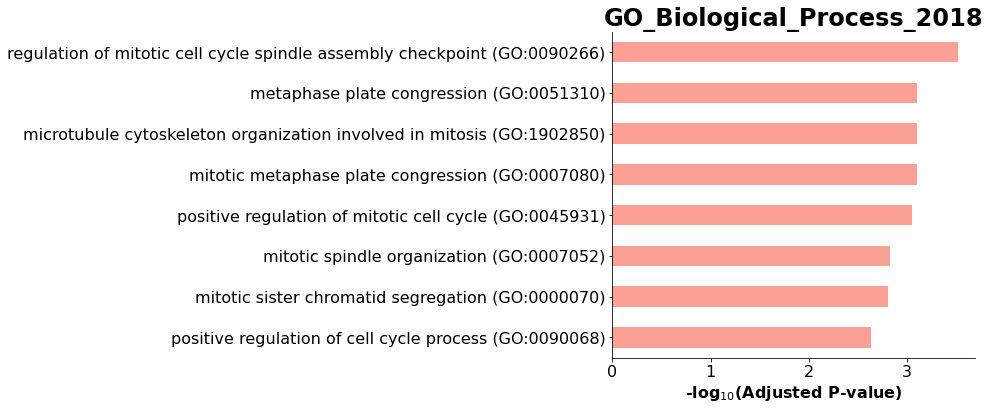

In [275]:
# Barplot
barplot(enr.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
        cutoff=0.01, top_term=20, figsize=(6.5, 6), color='salmon', ofname=None)

## Impurity of the clusters
Compute the Gini-impurity (0-0.5) has a measure of the impurity of the clusters (should be as low as possible)

In [351]:
# Function to calculate the gini impurity'
def gini(cluster_list, loci_clusters):
    # create a df with the amount of positive and negative loci per cluster
    impurity = pd.DataFrame({'cluster': cluster_list})
    impurity['n'] = [len(loci_clusters[(loci_clusters['cluster']==cluster)]) for cluster in cluster_list]
    impurity['prob_pos'] = [len(loci_clusters[(loci_clusters['cluster']==cluster) &
                                              (loci_clusters['sign']=="positive")]) / 
                                  len(loci_clusters[loci_clusters['cluster']==cluster]) 
                                  for cluster in cluster_list]
    impurity['prob_neg'] = 1 - impurity['prob_pos']
    # calculate gini per cluster
    impurity['gini'] = 1 - impurity['prob_pos']**2 - impurity['prob_neg']**2
    # weight gini values according to cluster size
    n_total = impurity['n'].sum()
    impurity['gini_weighted'] = impurity.apply(lambda row: row['n']/n_total * row['gini'], axis=1)
    return(impurity['gini_weighted'].sum())

In [352]:
# Gini Index for clusters with more than one locus
mult_loci_IMR90 = cluster_statistics_IMR90.loc[cluster_statistics_IMR90['number_loci']>1, 'cluster'].tolist()
gini_IMR90 = gini(mult_loci_IMR90, loci_clusters_IMR90)
gini_IMR90

0.23719008264462807

In [353]:
mult_loci_old = cluster_statistics_old_fibroblasts.loc[cluster_statistics_old_fibroblasts['number_loci']>1, 'cluster'].tolist()
gini_old_fibroblasts = gini(mult_loci_old, loci_clusters_old_fibroblasts)
gini_old_fibroblasts

0.29858682082708055

## Histogram of the distributions of positive vs negative loci

In [354]:
# convert to long format
IMR90.reset_index(inplace=True)
IMR90_long = pd.melt(IMR90, id_vars = ['chr1'])
IMR90_long.columns = ['chr1', 'chr2', 'value']
IMR90 = IMR90.set_index('chr1')

old_fibroblasts.reset_index(inplace=True)
old_fibroblasts_long = pd.melt(old_fibroblasts, id_vars = ['chr1'])
old_fibroblasts_long.columns = ['chr1', 'chr2', 'value']
old_fibroblasts = old_fibroblasts.set_index('chr1')

In [355]:
# Separate loci into the ones with positive and negative weights
IMR90_pos = IMR90_long[(IMR90_long['chr1'].isin(pos_weights['locus'].tolist())) & 
                       (IMR90_long['chr2'].isin(pos_weights['locus'].tolist())) ]
IMR90_neg = IMR90_long[(IMR90_long['chr1'].isin(neg_weights['locus'].tolist())) & 
                       (IMR90_long['chr2'].isin(neg_weights['locus'].tolist())) ]
IMR90_mixed = IMR90_long[(IMR90_long['chr1'].isin(pos_weights['locus'].tolist())) & 
                       (IMR90_long['chr2'].isin(neg_weights['locus'].tolist())) ]

old_fibroblasts_pos = old_fibroblasts_long[(old_fibroblasts_long['chr1'].isin(pos_weights['locus'].tolist())) & 
                       (old_fibroblasts_long['chr2'].isin(pos_weights['locus'].tolist())) ]
old_fibroblasts_neg = old_fibroblasts_long[(old_fibroblasts_long['chr1'].isin(neg_weights['locus'].tolist())) & 
                       (old_fibroblasts_long['chr2'].isin(neg_weights['locus'].tolist())) ]
old_fibroblasts_mixed = old_fibroblasts_long[(old_fibroblasts_long['chr1'].isin(pos_weights['locus'].tolist())) & 
                       (old_fibroblasts_long['chr2'].isin(neg_weights['locus'].tolist())) ]

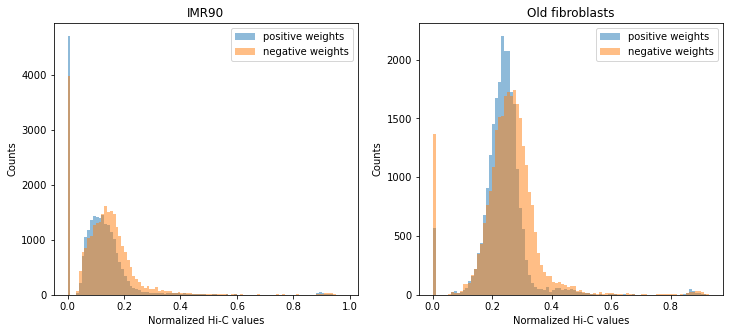

In [356]:
# Plot histograms
binwidth = 0.01

plt.figure(figsize = (12,5))
# IMR90
plt.subplot(1, 2, 1)
MEFISTO.plot_hist(IMR90_pos, IMR90_neg, binwidth, "IMR90")
# Old fibroblasts
plt.subplot(1, 2, 2)
MEFISTO.plot_hist(old_fibroblasts_pos, old_fibroblasts_neg, binwidth, "Old fibroblasts")
plt.savefig(save_dir+'hist_pos_neg_top10.png')

## Wilcoxon rank sum test

In [357]:
# IMR90
ranksums(IMR90_pos['value'],IMR90_neg['value']).pvalue

3.2371827606319137e-267

In [358]:
# Old fibroblasts
ranksums(old_fibroblasts_pos['value'],old_fibroblasts_neg['value']).pvalue

8.352517514678056e-294

## Eigen Decomposition

In [359]:
# IMR90
#delta = 0.1
#D = np.diag(np.sum(IMR90, axis=1))
#inv_sqrt_D = np.linalg.inv(np.power(D, 1/2))
#L = np.linalg.multi_dot([inv_sqrt_D, IMR90, inv_sqrt_D]) + delta * np.identity(len(IMR90.index))
#eigenvalues_y, eigenvectors_y = eigh(L)
eigenvalues_y, eigenvectors_y = eigh(IMR90)

# Old fibroblasts
eigenvalues_o, eigenvectors_o = eigh(old_fibroblasts)

In [360]:
# Sort eigenvalues in descending order
# IMR90
order = np.argsort(-np.abs(eigenvalues_y))
eigenvalues_y = eigenvalues_y[order]
eigenvectors_y = eigenvectors_y.T[order].T

# Old fibroblasts
order = np.argsort(-np.abs(eigenvalues_o))
eigenvalues_o = eigenvalues_o[order]
eigenvectors_o = eigenvectors_o.T[order].T

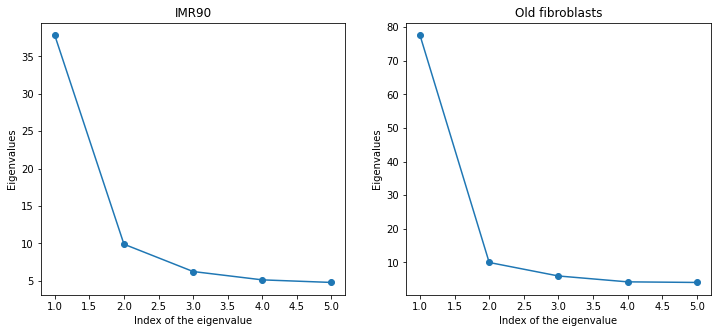

In [361]:
# Plot the eigenvalues

plt.figure(figsize = (12,5))

# IMR90
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 5+1)), eigenvalues_y[0:5], '-o')
plt.title('IMR90')
plt.xlabel('Index of the eigenvalue')
plt.ylabel('Eigenvalues')

# Old fibroblasts
plt.subplot(1, 2, 2)
plt.plot(list(range(1, 5+1)), eigenvalues_o[0:5], '-o')
plt.title('Old fibroblasts')
plt.xlabel('Index of the eigenvalue')
plt.ylabel('Eigenvalues')

plt.savefig(save_dir+'elbow.png')
plt.show()

In [362]:
# Create df with eigenvectors and sign of the corresponding loci

# IMR90
eigenvectors_y_df = pd.DataFrame({'locus': IMR90.index, 
                                 'v1': eigenvectors_y[:, 0],
                                 'v2': eigenvectors_y[:, 1]})
eigenvectors_y_df['sign'] = np.where(eigenvectors_y_df['locus'].isin(pos_weights['locus'].tolist()), "positive", "negative")

# Old fibroblasts
eigenvectors_o_df = pd.DataFrame({'locus': old_fibroblasts.index, 
                                 'v1': eigenvectors_o[:, 0],
                                 'v2': eigenvectors_o[:, 1]})
eigenvectors_o_df['sign'] = np.where(eigenvectors_o_df['locus'].isin(pos_weights['locus'].tolist()), "positive", "negative")

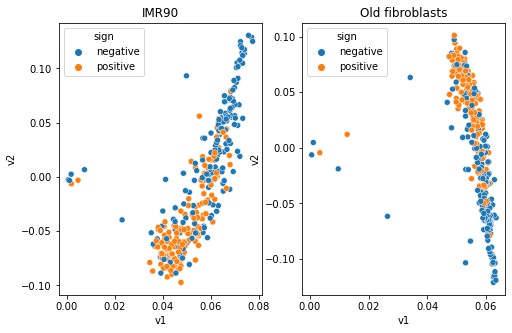

In [363]:
# Plot the first two eigenvectors and color according to the sign of each locus
plt.figure(figsize = (8,5))

# IMR90
plt.subplot(1, 2, 1)
sns.scatterplot(data=eigenvectors_y_df, x='v1', y='v2', hue='sign')
plt.title('IMR90')

# Old fibroblasts
plt.subplot(1, 2, 2)
sns.scatterplot(data=eigenvectors_o_df, x='v1', y='v2', hue='sign')
plt.title('Old fibroblasts')
plt.savefig(save_dir+'eigenvectors.png')
plt.show()

## K nearest neighbours

In [364]:
# Function to get the mean percentage of the correct sign of the knn
def knn(k, dist_matrix, eigenvectors_df):
    perc_correct = []

    for ix in eigenvectors_df.index:
        # Get the correct sign of the locus
        correct_sign = eigenvectors_df['sign'][ix]
        # Get list of indices of the k nearest neighbours
        knn = np.argsort(dist_matrix[:, ix])[1:k+1].tolist()
        # Get list of the signs of the neighbours
        signs = eigenvectors_df.loc[eigenvectors_df.index.isin(knn),'sign'].tolist()
        # Calculate percentage of correct signs
        perc = signs.count(correct_sign) / k
        perc_correct.append(perc)
        
    return(np.mean(perc_correct))

# Function for getting a null distribution by simulation with swapped sign labels
def null_dist(num_sim, k, dist_matrix, eigenvectors_df): 
    null_dist = []
    random_labels = np.random.choice(['positive', 'negative'], (len(eigenvectors_df.index), num_sim))

    for sim in tqdm(range(num_sim)):
        time.sleep(0.01)
        # swap signs
        df_random = eigenvectors_df
        df_random['sign'] = random_labels[:,sim-1]

        # get mean percentage of correct labels
        perc_correct = knn(k, dist_matrix, df_random)
        null_dist.append(perc_correct)
        
    return(null_dist)

In [365]:
k = 3

# IMR90
# Calculate pairwise euclidean distances
distances_y = euclidean_distances(eigenvectors_y[:, 0:2], eigenvectors_y[:, 0:2])
# Get mean of percentage of correct labels in the k nearest neighbours 
IMR90_perc_correct = knn(k, distances_y, eigenvectors_y_df)

# Old fibroblasts
# Calculate pairwise euclidean distances
distances_o = euclidean_distances(eigenvectors_o[:, 0:2], eigenvectors_o[:, 0:2])
# Get mean of percentage of correct labels in the k nearest neighbours 
old_perc_correct = knn(k, distances_o, eigenvectors_o_df)

print('IMR90: ' + str(IMR90_perc_correct))
print('Old fibroblasts: ' + str(old_perc_correct))

IMR90: 0.6163522012578616
Old fibroblasts: 0.6467505241090147


In [366]:
# Run 1000 simulations with swapped labels to obtain null distribution
num_sim = 1000
np.random.seed(2022)
null_dist_IMR90 = null_dist(num_sim, k, distances_y, eigenvectors_y_df)
null_dist_old = null_dist(num_sim, k, distances_o, eigenvectors_o_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:22<00:00, 12.07it/s]


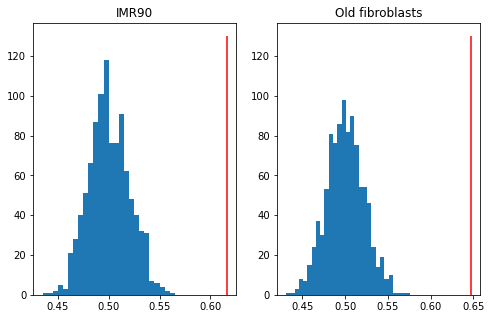

In [367]:
# Plot histogram of the results
binwidth = 0.005
plt.figure(figsize = (8,5))

# IMR90
plt.subplot(1, 2, 1)
plt.hist(null_dist_IMR90,
         bins=np.arange(min(null_dist_IMR90), max(null_dist_IMR90) + binwidth, binwidth))
plt.vlines(IMR90_perc_correct, 0, 130, colors = 'red')
plt.title('IMR90')

# Old fibroblasts
plt.subplot(1, 2, 2)
plt.hist(null_dist_old,
         bins=np.arange(min(null_dist_old), max(null_dist_old) + binwidth, binwidth))
plt.vlines(old_perc_correct, 0, 130, colors = 'red')
plt.title('Old fibroblasts')
plt.savefig(save_dir+'hist_eigen_decomp_null_dist.png')

plt.show()